# 10720PHYS401200 Homework-4

## Problem 1: Singular values of Bell states and random states.

Consider a two spin-1/2 system with basis $|11\rangle,|10\rangle,|01\rangle,|00\rangle$. An arbitrary state can be expressed as $|\psi\rangle=\sum_{i,j}\psi_{i,j}|ij\rangle$. The Bell states are
$$
\frac{1}{\sqrt{2}}|00\rangle+|11\rangle,
\frac{1}{\sqrt{2}}|00\rangle-|11\rangle,
\frac{1}{\sqrt{2}}|01\rangle+|10\rangle,
\frac{1}{\sqrt{2}}|01\rangle-|10\rangle.
$$

* Now treat $\psi_{i,j}$ as matrix elements and perform SVD to get singular values $\lambda_1, \lambda_2$.
* The entanglement entropy $S$ is defined as $S= -\sum_i \lambda_i \ln \lambda_i$. Find the entanglement entropy of the Bell states.
* Perform the same analysis on random state. What is the average entanglement entropy?

In [1]:
import Tor10
import copy
import numpy as np
import matplotlib.pyplot as plt

In [7]:
bd = Tor10.Bond(2) 
up_ket = Tor10.UniTensor(bonds=[bd], N_rowrank=1, name="|+>")
up_ket.SetElem([1, 0])
dn_ket = Tor10.UniTensor(bonds=[bd], N_rowrank=1, name="|->")
dn_ket.SetElem([0, 1])

up1_ket = copy.deepcopy(up_ket)
up2_ket = copy.deepcopy(up_ket)
dn1_ket = copy.deepcopy(dn_ket)
dn2_ket = copy.deepcopy(dn_ket)

up1_ket.SetLabels([0])
up2_ket.SetLabels([1])
dn1_ket.SetLabels([0])
dn2_ket.SetLabels([1])

up1up2_ket = Tor10.Contract(up1_ket, up2_ket)
up1up2_ket.SetName('|11>')
up1dn2_ket = Tor10.Contract(up1_ket, dn2_ket)
up1dn2_ket.SetName('|10>')
dn1up2_ket = Tor10.Contract(dn1_ket, up2_ket)
dn1up2_ket.SetName('|01>')
dn1dn2_ket = Tor10.Contract(dn1_ket, dn2_ket)
dn1dn2_ket.SetName('|00>')

Bell1 = (dn1dn2_ket + up1up2_ket) / (2**0.5)
Bell1.Permute([0,1], N_rowrank=1)
Bell2 = (dn1dn2_ket - up1up2_ket ) / (2**0.5)
Bell2.Permute([0,1], N_rowrank=1)
Bell3 = (dn1up2_ket + up1dn2_ket) / (2**0.5)
Bell3.Permute([0,1], N_rowrank=1)
Bell4 = (dn1up2_ket - up1dn2_ket) / (2**0.5)
Bell4.Permute([0,1], N_rowrank=1)

u1, s1, vt1 = Bell1.Svd()
u2, s2, vt2 = Bell2.Svd()
u3, s3, vt3 = Bell3.Svd()
u4, s4, vt4 = Bell4.Svd()

s = [s1, s2, s3, s4]
Bell = ['|00>+|11>', '|00>-|11>', '|01>+|10>', '|01>-|10>']
for i, state in enumerate(Bell):
    S = 0
    for j in range(len(s[i])):
        S += -1*(s[i][j].item()) * np.log(s[i][j].item())
    print('Bell State %s entanglement entropy: %.6f' % (state, S))

runs = 1
rounds = 100000
for _ in range(runs):
    S_list = []
    for i in range(rounds):
        bd = Tor10.Bond(2)
        Random = Tor10.UniTensor([bd, bd], N_rowrank=1, name='Random', labels=[0,1])
        Random.Rand()
        u, s,vt = Random.Svd()
        S = 0
        for j in range(len(s)):
            S += -1*s[j].item() * np.log(s[j].item())
        S_list.append(S)
    print('Rand State mean entropy for %i rounds: %.6f' % (rounds, np.mean(S_list)))

Bell State |00>+|11> entanglement entropy: 0.490129
Bell State |00>-|11> entanglement entropy: 0.490129
Bell State |01>+|10> entanglement entropy: 0.490129
Bell State |01>-|10> entanglement entropy: 0.490129
Rand State mean entropy for 100000 rounds: 0.137751


## Problem 2: iTEBD for 1D quantum transverse field Ising model

Implement iTEBD algorithm for the 1D (ferromagnetic) Transfer Field Ising Model (TFIM) with following Hamiltonian:
$$
  H 
  = \sum_i -J \sigma^z_i \sigma^z_{i+1} - h \sigma^x_i
  = \sum_i -J \sigma^z_i \sigma^z_{i+1} - \frac{h}{2} \left( \sigma^x_i I_{i+1} + I_i \sigma^x_{i+1}\right)
  = \sum_i h_{i,i+1}.
$$
$$
  h_{i,i+1} = -J \sigma^z_i \sigma^z_{i+1} - \frac{h}{2} \left( \sigma^x_i I_{i+1} + I_i \sigma^x_{i+1}\right).
$$

You can set $J=1$ as the energy unit.

Show that
* For $J=1$, $h=0$ one has $\langle \sigma^z\rangle=\pm 1$ and $\langle \sigma^x\rangle=0$.
* FOr $J=1$, $h\gg 1$ one has $\langle \sigma^z\rangle \approx 0$ and $\langle \sigma^x \rangle \approx 1$.

Plot
* $\langle E \rangle$ as a function of $h$,
* $\langle \sigma^z\rangle$ as a function of $h$,
* $\langle \sigma^x\rangle$ as a function of $h$,
for a couple of different bond dimensions $D$. 

Show that the there is a critical point near $h=1$.

In [2]:
# one-site operators
Id = Tor10.UniTensor(bonds=[Tor10.Bond(2), Tor10.Bond(2)], N_rowrank=1, name = 'Id')
Id.SetElem([1, 0,\
            0, 1])
Sx = Tor10.UniTensor(bonds=[Tor10.Bond(2), Tor10.Bond(2)], N_rowrank=1, name = 'Sx')
Sx.SetElem([0, 1,\
            1, 0])
Sz = Tor10.UniTensor(bonds=[Tor10.Bond(2), Tor10.Bond(2)], N_rowrank=1, name = 'Sz')
Sz.SetElem([1, 0,\
            0,-1])

# attach site index
Id1 = copy.deepcopy(Id)
Id2 = copy.deepcopy(Id)
Sx1 = copy.deepcopy(Sx)
Sx2 = copy.deepcopy(Sx)
Sz1 = copy.deepcopy(Sz)
Sz2 = copy.deepcopy(Sz)

# two-site operators
# Sz1⨂Sz2
Sz1.SetLabels([0, 2])
Sz2.SetLabels([1, 3])
Sz1_Sz2 = Tor10.Contract(Sz1, Sz2)
Sz1_Sz2.SetName('Sz1⨂Sz2')

# Sx1⨂Id2
Sx1.SetLabels([0, 2])
Id2.SetLabels([1, 3])
Sx1_Id2 = Tor10.Contract(Sx1, Id2)
Sx1_Id2.SetName('Sx1⨂Id2')

# Id1⨂Sx2
Id1.SetLabels([0, 2])
Sx2.SetLabels([1, 3])
Id1_Sx2 = Tor10.Contract(Id1, Sx2)
Id1_Sx2.SetName('Id1⨂Sx2')

# Sz1⨂Id2
Sz1.SetLabels([0, 2])
Id2.SetLabels([1, 3])
Sz1_Id2 = Tor10.Contract(Sz1, Id2)
Sz1_Id2.SetName('Sz1⨂Id2')

# Id1⨂Sz2
Id1.SetLabels([0, 2])
Sz2.SetLabels([1, 3])
Id1_Sz2 = Tor10.Contract(Id1, Sz2)
Id1_Sz2.SetName('Id1⨂Sx2')

print('Operator setting complete ...')

Operator setting complete ...


In [3]:
def ITEBD(hx=1.0, D=20, dtau=0.1, J=1.0, loop=100):
    Ham_12 = Sz1_Sz2*(-J) - (Sx1_Id2+Id1_Sx2)*hx/2
    Ham_12.SetName('Ham_12')
    expH = Tor10.ExpH(Ham_12.GetBlock()*(-dtau))
    expH_12 = Tor10.UniTensor(bonds=Ham_12.bonds, N_rowrank=2, name='exp(H_12*(-dtau))')
    expH_12.PutBlock(expH)
    
    ## Create MPS:
    #
    #     |    |     
    #   --A-la-B-lb-- 
    
    A = Tor10.UniTensor(bonds=[Tor10.Bond(D), Tor10.Bond(2), Tor10.Bond(D)], N_rowrank=1, labels=[-1,0,-2])
    A.Rand()
    A.SetName('A')
    
    B = Tor10.UniTensor(bonds=A.bonds,N_rowrank=1,labels=[-3,1,-4])
    B.Rand()
    B.SetName('B')

    la = Tor10.UniTensor(bonds=[Tor10.Bond(D),Tor10.Bond(D)], N_rowrank=1, labels=[-2,-3],is_diag=True)
    la.Rand()
    la.SetName('la')

    lb = Tor10.UniTensor(bonds=la.bonds, N_rowrank=1, labels=[-4,-5],is_diag=True)
    lb.Rand()
    lb.SetName('lb')

    for i in range(100):
        A.SetLabels([-1,0,-2])
        B.SetLabels([-3,1,-4])
        la.SetLabels([-2,-3])
        lb.SetLabels([-4,-5])

        ## X =
        #           (0)  (1)
        #            |    |     
        #  (-4) --lb-A-la-B-lb-- (-5) 
            
        X = Tor10.Contract(Tor10.Contract(A,la),Tor10.Contract(B,lb))
        lb.SetLabel(-1,idx=1)
        X = Tor10.Contract(lb,X)  
        X.SetName('X')
    
        # <MPS|MPS>
        XNorm = Tor10.Contract(X, X)
        
        # <MPS|Ham_12|MPS>    
        XH = Tor10.Contract(X, Ham_12)
        XH.SetName('XH')
        XH.SetLabels([-4,-5,0,1])
        XHX = Tor10.Contract(X, XH)
        E = XHX / XNorm

        # <MPS|Id1_Sz2|MPS>    
        Z2H = Tor10.Contract(X, Id1_Sz2)
        Z2H.SetName('Z2H')
        Z2H.SetLabels([-4,-5,0,1])
        XZ2X = Tor10.Contract(X, Z2H)
        
        # <MPS|Id1_Sx2|MPS>    
        X2H = Tor10.Contract(X, Id1_Sx2)
        X2H.SetName('Z2H')
        X2H.SetLabels([-4,-5,0,1])
        XX2X = Tor10.Contract(X, X2H)
        
        # imaginary time evolution
        XeH = Tor10.Contract(X,expH_12)
        XeH.SetName('XeH')
        XeH.Permute([-4,2,3,-5],by_label=True)
        XeH.Contiguous()
        XeH = XeH.Reshape([D*2,D*2],N_rowrank=1)
    
        A,la,B = Tor10.Svd_truncate(XeH,D)
        la *= la.Norm()**-1 # re-normalize the norm of la
        A = A.Reshape([D,2,D], new_labels=[-1,0,-2], N_rowrank=1)
        B = B.Reshape([D,2,D], new_labels=[-3,1,-4], N_rowrank=1)

        # de-contract the lb tensor , so it returns to 
        #             
        #            |     |     
        #       --lb-A'-la-B'-lb-- 
        #
        # again, but A' and B' are updated 

        lb_inv = Tor10.Inverse(lb)
        A = Tor10.Contract(lb_inv, A)
        B = Tor10.Contract(B, lb_inv)

        # translation symmetry, exchange A and B site
        A,B = B,A
        la,lb = lb,la
        
    return E, XZ2X, XX2X

### Part1 - Show that
* For $J=1$, $h=0$ one has $\langle \sigma^z\rangle=\pm 1$ and $\langle \sigma^x\rangle=0$.
* FOr $J=1$, $h\gg 1$ one has $\langle \sigma^z\rangle \approx 0$ and $\langle \sigma^x \rangle \approx 1$.

In [4]:
E1, Z1, X1 = ITEBD(hx=  0.0, D=10, dtau=0.1, J=1.0, loop=1000)
E2, Z2, X2 = ITEBD(hx=100.0, D=10, dtau=0.1, J=1.0, loop=1000)

In [5]:
print('J=1, h=  0, ⟨𝜎𝑧⟩=%.10f, ⟨𝜎𝑥⟩=%.10f' % (Z1.item(), X1.item()))
print('J=1, h=100, ⟨𝜎𝑧⟩=%.10f, ⟨𝜎𝑥⟩=%.10f' % (Z2.item(), X2.item()))

J=1, h=  0, ⟨𝜎𝑧⟩=0.9999999996, ⟨𝜎𝑥⟩=0.0000000046
J=1, h=100, ⟨𝜎𝑧⟩=0.0000000000, ⟨𝜎𝑥⟩=0.9999750012


### Part2 - Plot
* $\langle E \rangle$ as a function of $h$,
* $\langle \sigma^z\rangle$ as a function of $h$,
* $\langle \sigma^x\rangle$ as a function of $h$,
for a couple of different bond dimensions $D$. 

Show that the there is a critical point near $h=1$.

D=5 ...
D=10 ...
D=15 ...
D=20 ...


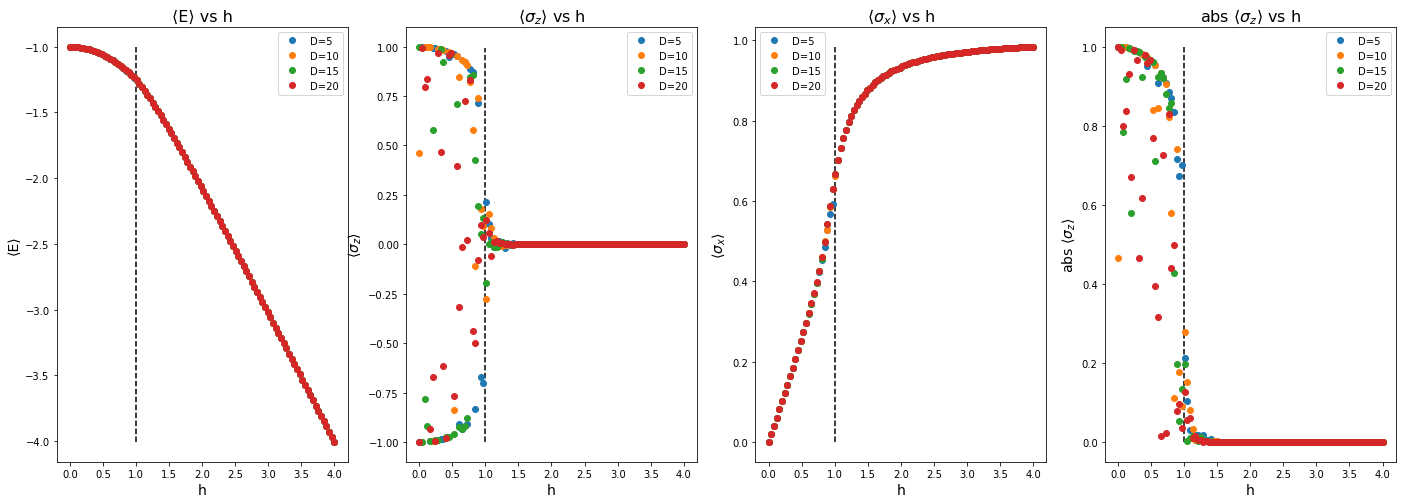

In [7]:
points = 100
D_list = [5, 10, 15, 20]
h_list = np.linspace(0, 4, points, endpoint=True)
ylabel_list = [r'⟨E⟩', r'$⟨\sigma_z⟩$', r'$⟨\sigma_x⟩$', r'abs $⟨\sigma_z⟩$']
title_list = [r'⟨E⟩ vs h', r'$⟨\sigma_z⟩$ vs h', r'$⟨\sigma_x⟩$ vs h', r'abs $⟨\sigma_z⟩$ vs h']

fig, axes = plt.subplots(1, 4, figsize=(24, 8))
for D in D_list:
    print('D=%i ...' % D)
    
    E_list, Z_list, X_list, abs_Z_list = [], [], [], []
    for h in h_list:
        E, Z, X = ITEBD(hx=h, D=D)
        E_list.append(E.item())
        Z_list.append(Z.item())
        X_list.append(X.item())
        abs_Z_list.append(abs(Z.item()))
                          
    plot_list = [E_list, Z_list, X_list, abs_Z_list]    
    for i in range(len(plot_list)):
        axes[i].plot(h_list, plot_list[i], 'o', label='D=%i' % D)
        axes[i].set_title(title_list[i], fontsize=16)
        axes[i].set_ylabel(ylabel_list[i], fontsize=14)
        axes[i].set_xlabel('h', fontsize=14)
        axes[i].legend()

for i in range(len(plot_list)):
    axes[i].vlines(x=1.0, ymin=min(plot_list[i]), ymax=max(plot_list[i]), linestyles='dashed', label='h=1.0')
plt.savefig('result.png')
plt.show()